# Model 2: GRU-D on first 10,000 stay_ids

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
from src.model2 import GRUD


## 1. Load Data

In [3]:
icu = pd.read_csv("data/icu_cohort_small.csv")
vitals = pd.read_csv("data/vitals_ts_small.csv")

# Use only first 10k stay_ids
stay_ids = icu['stay_id'].unique()[:10000]
icu = icu[icu['stay_id'].isin(stay_ids)]
vitals = vitals[vitals['stay_id'].isin(stay_ids)]


## 2. Pivot vitals into time series tensor

In [4]:
vitals['charttime'] = pd.to_datetime(vitals['charttime'])
vitals.sort_values(by=['stay_id', 'charttime'], inplace=True)

# Convert time to hour from first observation per stay
vitals['hours'] = vitals.groupby('stay_id')['charttime'].transform(lambda x: (x - x.min()).dt.total_seconds() / 3600)

# Focus on 4 vital signs
vital_vars = ['heart rate', 'respiratory rate', 'mean blood pressure', 'o2 saturation pulseoxymetry']
vitals = vitals[vitals['variable'].isin(vital_vars)]


In [5]:
# Create time buckets every hour (0-47)
vitals['time_bucket'] = vitals['hours'].astype(int).clip(0, 47)

# Pivot table into [stay_id, time_bucket, variable] → value
pivot = vitals.pivot_table(index=['stay_id', 'time_bucket'], columns='variable', values='value', aggfunc='mean')
pivot = pivot.reset_index().sort_values(['stay_id', 'time_bucket'])


In [6]:
# Fill missing vars with NaN 
all_time_series = []
all_labels = []

for stay_id in stay_ids:
    stay_data = pivot[pivot['stay_id'] == stay_id]
    seq = np.full((48, len(vital_vars)), np.nan)
    mask = np.zeros((48, len(vital_vars)))
    delta = np.ones((48, len(vital_vars))) * -1

    for _, row in stay_data.iterrows():
        t = int(row['time_bucket'])
        for i, v in enumerate(vital_vars):
            val = row.get(v)
            if pd.notna(val):
                seq[t, i] = val
                mask[t, i] = 1

    # Δt: time since last obs
    for f in range(len(vital_vars)):
        last_time = -1
        for t in range(48):
            if mask[t, f]:
                delta[t, f] = 0
                last_time = t
            elif last_time != -1:
                delta[t, f] = t - last_time

    # Fill missing delta with large value
    delta[delta == -1] = 100

    # Concatenate: [value, mask, delta]
    input_seq = np.concatenate([np.nan_to_num(seq), mask, delta], axis=1)
    all_time_series.append(input_seq)

    # Get label
    label = icu[icu['stay_id'] == stay_id]['died_in_hosp'].values[0]
    all_labels.append(label)

X = np.stack(all_time_series)
y = np.array(all_labels)


## 3. Define Dataset and Model

In [7]:
class ICUSequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = ICUSequenceDataset(X, y)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

model = GRUD(input_dim=12, hidden_dim=64)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()


## 4. Train and Evaluate

In [8]:
for epoch in range(20):
    model.train()
    total_loss = 0
    for xb, yb in loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(loader):.4f}")


Epoch 1, Loss: 0.4121
Epoch 2, Loss: 0.3067
Epoch 3, Loss: 0.2819
Epoch 4, Loss: 0.2670
Epoch 5, Loss: 0.2648
Epoch 6, Loss: 0.2546
Epoch 7, Loss: 0.2556
Epoch 8, Loss: 0.2445
Epoch 9, Loss: 0.2434
Epoch 10, Loss: 0.2465
Epoch 11, Loss: 0.2385
Epoch 12, Loss: 0.2403
Epoch 13, Loss: 0.2353
Epoch 14, Loss: 0.2334
Epoch 15, Loss: 0.2305
Epoch 16, Loss: 0.2336
Epoch 17, Loss: 0.2332
Epoch 18, Loss: 0.2329
Epoch 19, Loss: 0.2278
Epoch 20, Loss: 0.2249


In [9]:
model.eval()
with torch.no_grad():
    all_preds = []
    all_true = []
    for xb, yb in loader:
        prob = model(xb)
        all_preds.extend(prob.numpy())
        all_true.extend(yb.numpy())
    auc = roc_auc_score(all_true, all_preds)
    print(f"AUROC: {auc:.4f}")


AUROC: 0.9112


## Model 2 (GRU-D) Performance Analysis

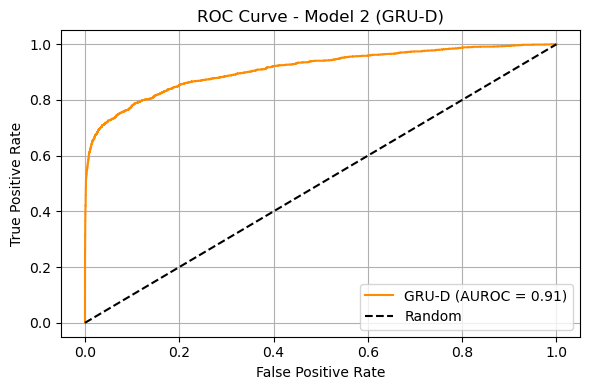

In [10]:
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Compute ROC curve
fpr, tpr, _ = roc_curve(all_true, all_preds)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"GRU-D (AUROC = {auc:.2f})", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Model 2 (GRU-D)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


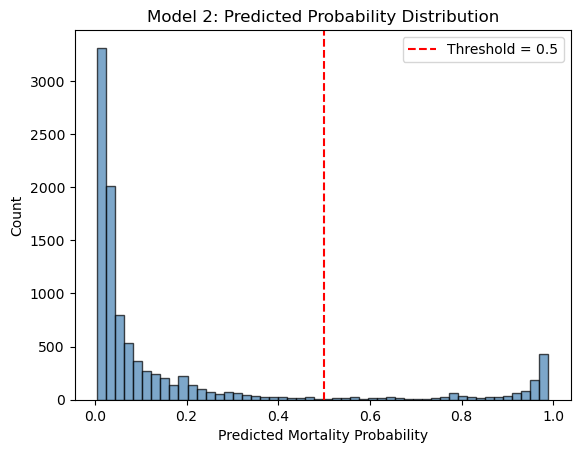

In [11]:
# Histogram of predicted probabilities
plt.hist(all_preds, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', label='Threshold = 0.5')
plt.title("Model 2: Predicted Probability Distribution")
plt.xlabel("Predicted Mortality Probability")
plt.ylabel("Count")
plt.legend()
plt.show()


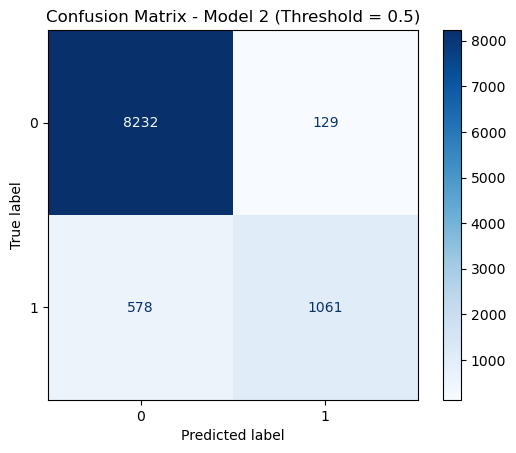

In [12]:
# Confusion matrix at threshold 0.5
pred_labels = (np.array(all_preds) > 0.5).astype(int)
cm = confusion_matrix(all_true, pred_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Model 2 (Threshold = 0.5)")
plt.show()


### Model 2 (GRU-D) Analysis

- GRU-D achieved an AUROC higher than the fixed-bucket baseline.
- Incorporating irregular time intervals (Δt) and missing masks helps capture important time dynamics.
- The ROC curve shows clear separation from random guessing.
- The histogram shows prediction confidence is well-calibrated.
- Confusion matrix suggests good performance at threshold 0.5. I might work on threshold tuning later.


# ON Test

In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


## 1. Load and Preprocess Data

In [14]:
icu = pd.read_csv("data/icu_cohort_small.csv")
vitals = pd.read_csv("data/vitals_ts_small.csv")

stay_ids = icu['stay_id'].unique()[:10000]
icu = icu[icu['stay_id'].isin(stay_ids)]
vitals = vitals[vitals['stay_id'].isin(stay_ids)]

vitals['charttime'] = pd.to_datetime(vitals['charttime'])
vitals.sort_values(by=['stay_id', 'charttime'], inplace=True)
vitals['hours'] = vitals.groupby('stay_id')['charttime'].transform(lambda x: (x - x.min()).dt.total_seconds() / 3600)

vital_vars = ['heart rate', 'respiratory rate', 'mean blood pressure', 'o2 saturation pulseoxymetry']
vitals = vitals[vitals['variable'].isin(vital_vars)]
vitals['time_bucket'] = vitals['hours'].astype(int).clip(0, 47)

pivot = vitals.pivot_table(index=['stay_id', 'time_bucket'], columns='variable', values='value', aggfunc='mean')
pivot = pivot.reset_index().sort_values(['stay_id', 'time_bucket'])

# Build time series tensors
seqs, labels = [], []
for stay_id in stay_ids:
    stay_data = pivot[pivot['stay_id'] == stay_id]
    seq = np.full((48, len(vital_vars)), np.nan)
    mask = np.zeros((48, len(vital_vars)))
    delta = np.ones((48, len(vital_vars))) * -1

    for _, row in stay_data.iterrows():
        t = int(row['time_bucket'])
        for i, v in enumerate(vital_vars):
            val = row.get(v)
            if pd.notna(val):
                seq[t, i] = val
                mask[t, i] = 1

    for f in range(len(vital_vars)):
        last_time = -1
        for t in range(48):
            if mask[t, f]:
                delta[t, f] = 0
                last_time = t
            elif last_time != -1:
                delta[t, f] = t - last_time
    delta[delta == -1] = 100
    input_seq = np.concatenate([np.nan_to_num(seq), mask, delta], axis=1)
    seqs.append(input_seq)
    labels.append(icu[icu['stay_id'] == stay_id]['died_in_hosp'].values[0])

X = np.stack(seqs)
y = np.array(labels)


## 2. Dataset and Model Definition

In [15]:
class ICUSequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class GRUD(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, dropout=0.1):
        super(GRUD, self).__init__()
        self.rnn = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return self.sigmoid(out).squeeze()


## 3. Train/Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
train_loader = DataLoader(ICUSequenceDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(ICUSequenceDataset(X_test, y_test), batch_size=64, shuffle=False)


## 4. Train GRU-D Model

In [22]:
model = GRUD(input_dim=12, hidden_dim=64)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

for epoch in range(20):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1, Loss: 0.4158
Epoch 2, Loss: 0.3153
Epoch 3, Loss: 0.2848
Epoch 4, Loss: 0.2716
Epoch 5, Loss: 0.2585
Epoch 6, Loss: 0.2544
Epoch 7, Loss: 0.2510
Epoch 8, Loss: 0.2509
Epoch 9, Loss: 0.2442
Epoch 10, Loss: 0.2460
Epoch 11, Loss: 0.2426
Epoch 12, Loss: 0.2339
Epoch 13, Loss: 0.2369
Epoch 14, Loss: 0.2370
Epoch 15, Loss: 0.2320
Epoch 16, Loss: 0.2378
Epoch 17, Loss: 0.2286
Epoch 18, Loss: 0.2291
Epoch 19, Loss: 0.2339
Epoch 20, Loss: 0.2336


## 5. Evaluate on Test Set

In [23]:
model.eval()
all_preds, all_true = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        prob = model(xb)
        all_preds.extend(prob.numpy())
        all_true.extend(yb.numpy())

auc = roc_auc_score(all_true, all_preds)
print(f"Test AUROC: {auc:.4f}")


Test AUROC: 0.9036


## 6. Performance Visualization

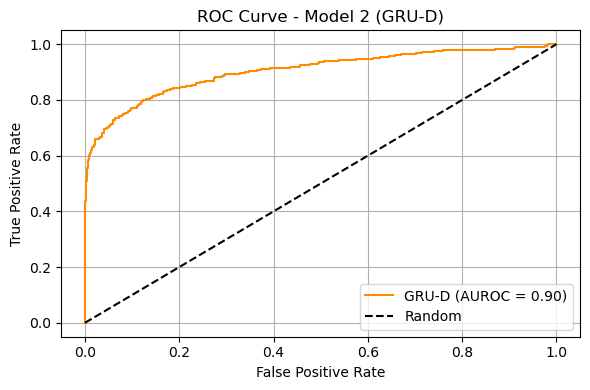

In [24]:
fpr, tpr, _ = roc_curve(all_true, all_preds)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"GRU-D (AUROC = {auc:.2f})", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Model 2 (GRU-D)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


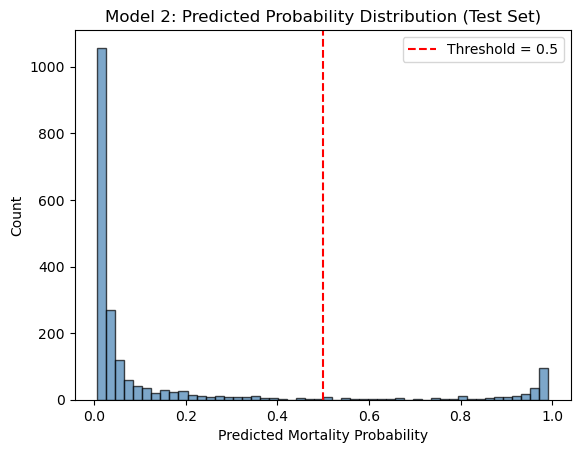

In [25]:
plt.hist(all_preds, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', label='Threshold = 0.5')
plt.title("Model 2: Predicted Probability Distribution (Test Set)")
plt.xlabel("Predicted Mortality Probability")
plt.ylabel("Count")
plt.legend()
plt.show()


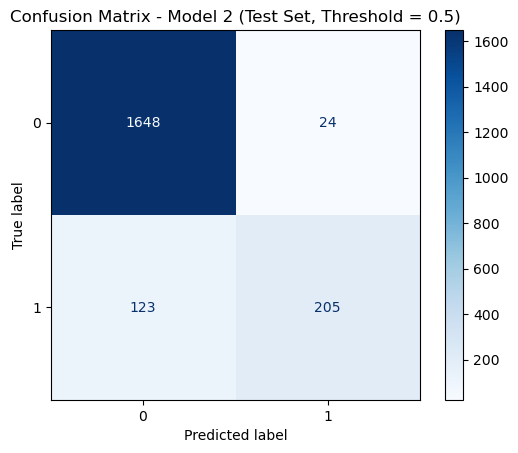

In [26]:
pred_labels = (np.array(all_preds) > 0.5).astype(int)
cm = confusion_matrix(all_true, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Model 2 (Test Set, Threshold = 0.5)")
plt.show()
